# Modeling MB dataset using Neural Network 

这个教程将详细展示如何使用神经网络模型对小鼠大脑矢状面前部数据集(mouse brain sagittal anterior)建模，包含具体的调参过程。

## 目录
* [数据预处理](#数据预处理)
  1. [读取数据](#读取数据)
* [制作数据集](#制作数据集)
  1. [标签与特征](#标签与特征)
  2. [划分数据集](#划分数据集)
* [神经网络模型](#神经网络模型)
  1. [调参](#调参)
  2. [构建模型](#构建模型)

## 数据预处理 <a class="anchor" id="数据预处理"></a>

首先，导入相关的库

In [1]:
import os
os.chdir("..")
import scanpy as sc
import numpy as np
import itertools

# 导入自己编写的库
from datapre import DataProcess as DP
from datapre import Sample as SP
from model import nn_model
from model import hyper_opt as hop
import evaluation as eval

sc.set_figure_params(facecolor = "white")
sc.settings.verbosity = 3
dirname = "mouse_brain_cell2location"

d:\anaconda3\envs\scanpy\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


设置默认的距离阈值为1.0

In [2]:
NEIGHBOR_DIS = 1.0

### 读取数据

标记线粒体基因，使用FeaturePlot函数可视化。

reading data\ST8059048\filtered_feature_bc_matrix.h5
 (0:00:00)


d:\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


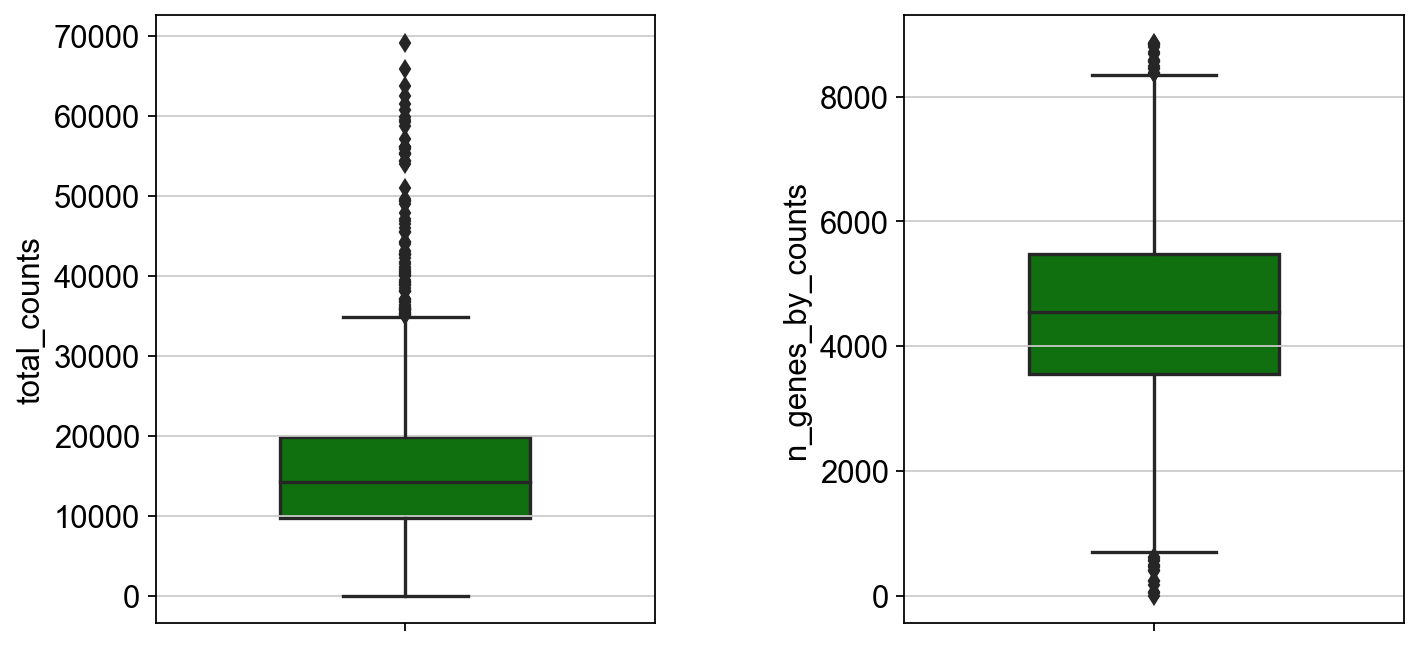

In [3]:
adata = sc.read_visium("data/ST8059048/")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars = ["mt"], inplace = True)
DP.FeaturePlot(adata)

过滤细胞数小于10的基因

In [4]:
sc.pp.filter_genes(adata, min_counts = 10)

filtered out 13924 genes that are detected in less than 10 counts


## 制作数据集

全局设置随机数种子

In [5]:
DP.setup_seed(38)

### 标签与特征

生成数据集标签

In [6]:
label_total, distance = DP.CreateLabel(adata, neighbor_dis = NEIGHBOR_DIS)

运行SpaGene，识别空间可变基因

In [7]:
DP.adata2seurat(adata, "ST8059048")
! Rscript spagene.R ST8059048 1000
spagene = DP.find_Spa("data/ST8059048/spagene.txt")

Loading required package: ggplot2
Loading required package: patchwork


进行归一化、对数化、标准化

In [8]:
adata = DP.data_final(adata, spagene = spagene)
count = adata.to_df().values

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


### 划分数据集

选择所有正样本，并按照1:2的比例抽取负样本

In [9]:
sample_index = SP.sample_data_index(label_total, neg_size = 2)
label, feature = SP.index2data(label_total, sample_index, count)

划分训练集和测试集

In [10]:
train_feature, train_label, test_feature, test_label = SP.split_dataset(label, feature)

train_feature = train_feature[:, 2:]
test_index = test_feature[:, [0,1]].astype("int32")
test_feature = test_feature[:, 2:]

## 神经网络模型

### 调参

这里需要优化的超参数有：
- 特征数 num_features
- 隐藏层结构 hidden_layer_sizes
- 丢弃率 dropout_rate
- 批量大小 batch_size

首先，我们进行随机搜索得到一组表现较好的超参数。

In [11]:
params_1 = {
    "num_features": range(100, 800, 100),
    "hidden_layer_sizes": list(itertools.product(range(200, 600, 100), (50, 100))),
    "dropout_rate": [0.0, 0.2, 0.5],
    "batch_size": [8, 16, 32, 64]
}
nnmodel_1 = nn_model.NeuralNetworkClassifier(verbose = False)
cv1 = hop.random_search(nnmodel_1, params_1, train_feature, train_label)

mean_score_time                                              0.13162
mean_test_loss                                             -0.190692
std_test_loss                                               0.005856
mean_test_auc                                               0.971519
std_test_auc                                                0.001574
rank_test_loss                                                     1
rank_test_auc                                                      2
params             {'num_features': 300, 'hidden_layer_sizes': (2...
Name: 22, dtype: object


In [12]:
cv1.best_params_

{'num_features': 300,
 'hidden_layer_sizes': (200, 50),
 'dropout_rate': 0.5,
 'batch_size': 16}

其次，在这组超参数的基础上逐个优化超参数

优化 num_features：网格搜索

mean_score_time                 0.088659
mean_test_loss                  -0.18825
std_test_loss                   0.012661
mean_test_auc                   0.970762
std_test_auc                    0.004173
rank_test_loss                         1
rank_test_auc                          4
params             {'num_features': 400}
Name: 3, dtype: object


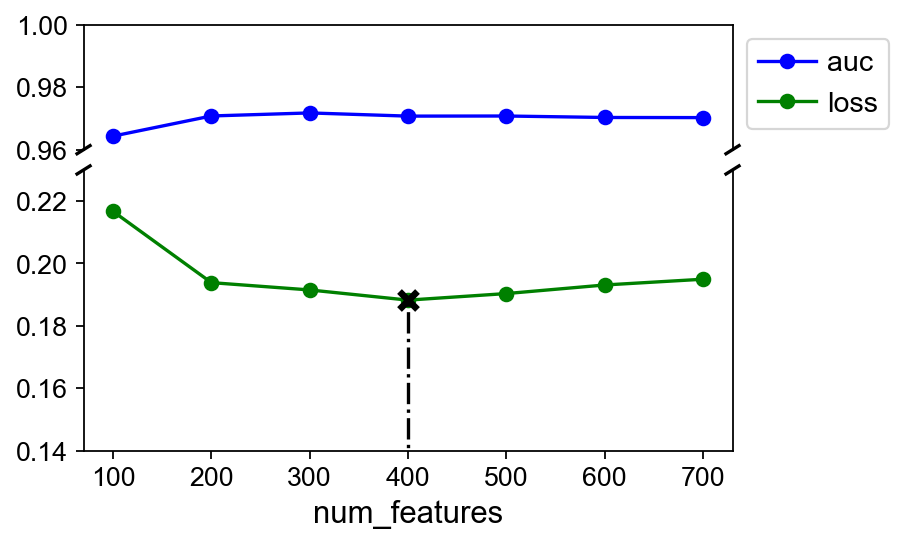

In [13]:
params_2 = {
    "num_features": range(100, 800, 100)
}
nnmodel_2 = nn_model.NeuralNetworkClassifier(
    verbose = False, 
    hidden_layer_sizes = cv1.best_params_["hidden_layer_sizes"], 
    dropout_rate = cv1.best_params_["dropout_rate"],
    batch_size = cv1.best_params_["batch_size"]
)
cv2 = hop.grid_search(nnmodel_2, params_2, train_feature, train_label, figname = dirname + "/NN_num_features")

In [14]:
cv2.best_params_

{'num_features': 300}

mean_score_time                 0.077354
mean_test_loss                 -0.184633
std_test_loss                   0.009219
mean_test_auc                   0.971953
std_test_auc                    0.003259
rank_test_loss                         1
rank_test_auc                          2
params             {'num_features': 375}
Name: 2, dtype: object


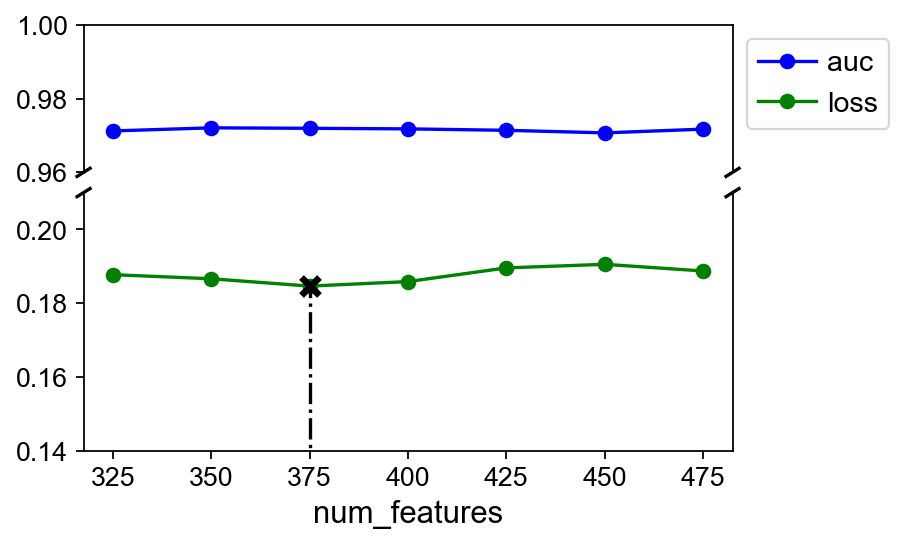

In [14]:
params_3 = {
    "num_features": [325, 350, 375, 400, 425, 450, 475]
}
nnmodel_3 = nn_model.NeuralNetworkClassifier(
    verbose = False, 
    hidden_layer_sizes = cv1.best_params_["hidden_layer_sizes"], 
    dropout_rate = cv1.best_params_["dropout_rate"],
    batch_size = cv1.best_params_["batch_size"]
)
cv3 = hop.grid_search(nnmodel_3, params_3, train_feature, train_label)

In [15]:
cv3.best_params_

{'num_features': 375}

优化 batch_size：网格搜索

mean_score_time              0.083015
mean_test_loss               -0.18255
std_test_loss                0.012518
mean_test_auc                0.973152
std_test_auc                 0.003163
rank_test_loss                      1
rank_test_auc                       1
params             {'batch_size': 32}
Name: 2, dtype: object


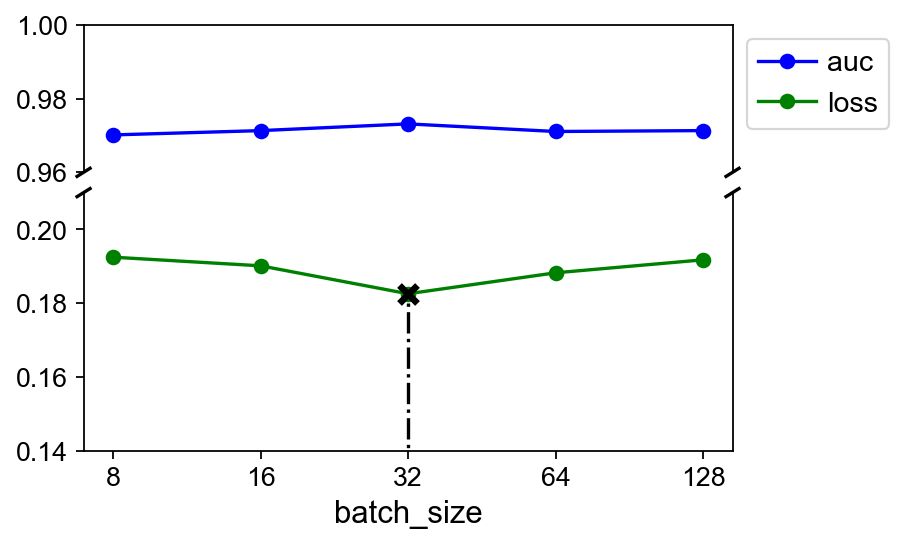

In [16]:
params_4 = {
    "batch_size": [8, 16, 32, 64, 128]
}
nnmodel_4 = nn_model.NeuralNetworkClassifier(
    verbose = False, 
    num_features = cv3.best_params_["num_features"], 
    hidden_layer_sizes = cv1.best_params_["hidden_layer_sizes"], 
    dropout_rate = cv1.best_params_["dropout_rate"]
)
cv4 = hop.grid_search(nnmodel_4, params_4, train_feature, train_label, figname = dirname + "/NN_batch_size")

In [17]:
cv4.best_params_

{'batch_size': 32}

优化 dropout_rate：网格搜索

mean_score_time                 0.060731
mean_test_loss                 -0.186338
std_test_loss                   0.008915
mean_test_auc                   0.971308
std_test_auc                    0.003544
rank_test_loss                         1
rank_test_auc                          1
params             {'dropout_rate': 0.5}
Name: 5, dtype: object


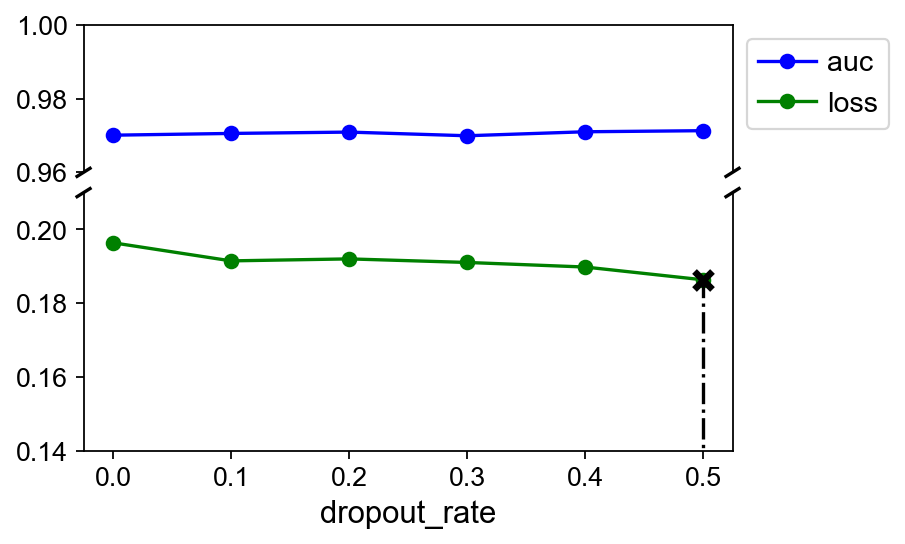

In [18]:
params_5 = {
    "dropout_rate": np.arange(0.0, 0.6, 0.1).round(1)
}
nnmodel_5 = nn_model.NeuralNetworkClassifier(
    verbose = False, 
    num_features = cv3.best_params_["num_features"], 
    batch_size = cv4.best_params_["batch_size"],
    hidden_layer_sizes = cv1.best_params_["hidden_layer_sizes"]
)
cv5 = hop.grid_search(nnmodel_5, params_5, train_feature, train_label, figname = dirname + "/NN_dropout_rate")

In [19]:
cv5.best_params_

{'dropout_rate': 0.5}

### 构建模型

第0轮，训练损失：0.3673
第0轮，验证损失：0.2330
Validation loss decreased (inf --> 0.233023).  Saving model ...
第1轮，训练损失：0.2559
第1轮，验证损失：0.2160
Validation loss decreased (0.233023 --> 0.216041).  Saving model ...
第2轮，训练损失：0.2307
第2轮，验证损失：0.1952
Validation loss decreased (0.216041 --> 0.195174).  Saving model ...
第3轮，训练损失：0.2083
第3轮，验证损失：0.1800
Validation loss decreased (0.195174 --> 0.179973).  Saving model ...
第4轮，训练损失：0.1946
第4轮，验证损失：0.1869
EarlyStopping counter: 1 out of 7
第5轮，训练损失：0.1786
第5轮，验证损失：0.1789
Validation loss decreased (0.179973 --> 0.178917).  Saving model ...
第6轮，训练损失：0.1777
第6轮，验证损失：0.1773
Validation loss decreased (0.178917 --> 0.177339).  Saving model ...
第7轮，训练损失：0.1635
第7轮，验证损失：0.1755
Validation loss decreased (0.177339 --> 0.175473).  Saving model ...
第8轮，训练损失：0.1609
第8轮，验证损失：0.1706
Validation loss decreased (0.175473 --> 0.170620).  Saving model ...
第9轮，训练损失：0.1536
第9轮，验证损失：0.1695
Validation loss decreased (0.170620 --> 0.169524).  Saving model ...
第10轮，训练损失：0.1484
第10轮，验证损失：0.1

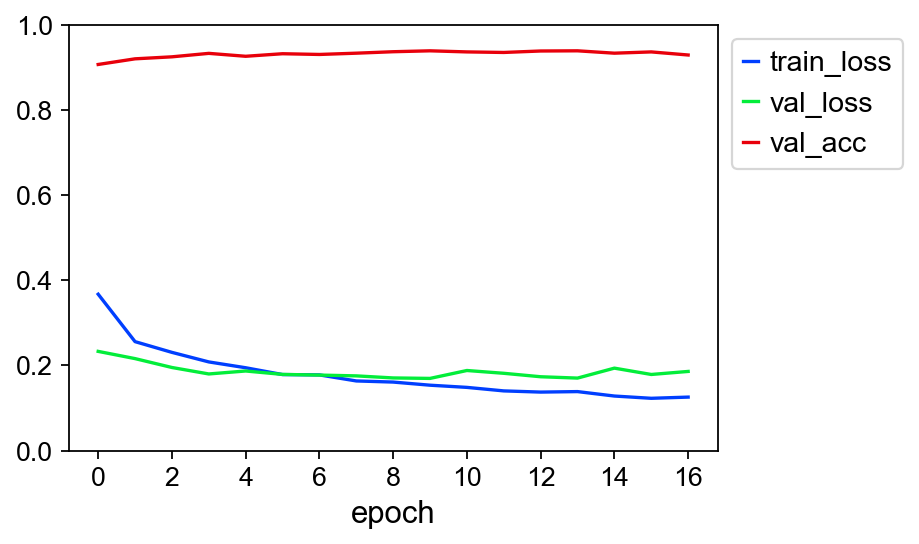

{'Accuracy': 0.9341294298921418,
 'Precision': 0.8526422764227642,
 'Recall': 0.9699421965317919,
 'MCC': 0.8609864201671712,
 'F_Score': 0.9075175770686857,
 'AUC': 0.9716439092642496,
 'Average Precision': 0.9201852187179268,
 'confusion_matrix': array([[1586,  145],
        [  26,  839]], dtype=int64)}

In [20]:
nnmodel = nn_model.NeuralNetworkClassifier(
    num_features = 375, 
    batch_size = 32,
    hidden_layer_sizes = (200, 50),
    dropout_rate = 0.5,
    figname = dirname + "/NN_epoch"
)
nnmodel.fit(train_feature, train_label)
pred = nnmodel.predict(test_feature)
predprob = nnmodel.predict_proba(test_feature)
eval.evaluate(test_label, pred, predprob, verbose = False)

In [12]:
import pickle
with open("mouse_brain_cell2location/data.pkl", "wb") as file:
    pickle.dump(nnmodel, file)

In [13]:
adata.var["gene_ids"].to_csv("mouse_brain_cell2location/adata.txt", sep = "\t")